# 1. Graph Construction

In [4]:
!pip install gensim
!pip install matplotlib
!pip install -U scikit-learn
!pip install torch_geometric
!pip install networkx
!pip3 install torch torchvision torchaudio
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html


In [5]:
import networkx as nx
from torch_geometric.datasets.planetoid import Planetoid
from torch_geometric.datasets.aminer import AMiner
from torch_geometric.utils import to_networkx, to_dense_adj

In [6]:
# Cora Dataset for GraRep
cora_data = Planetoid(root='/tmp/Cora', name='Cora')[0]

In [7]:
cora_data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
cora_A = to_dense_adj(cora_data.edge_index)[0]

In [9]:
cora_A.shape

torch.Size([2708, 2708])

In [11]:
# AMiner Dataset for Metapath2vec
!pip install pandas
aminer_data = AMiner("./")[0]

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/c3/6c/ea362eef61f05553aaf1a24b3e96b2d0603f5dc71a3bd35688a24ed88843/pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata
  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)


Processing...
Done!


In [12]:
aminer_data

HeteroData(
  author={
    y=[246678],
    y_index=[246678],
    num_nodes=1693531
  },
  venue={
    y=[134],
    y_index=[134],
    num_nodes=3883
  },
  paper={ num_nodes=3194405 },
  (paper, written_by, author)={ edge_index=[2, 9323605] },
  (author, writes, paper)={ edge_index=[2, 9323605] },
  (paper, published_in, venue)={ edge_index=[2, 3194405] },
  (venue, publishes, paper)={ edge_index=[2, 3194405] }
)

# 2. An example of Computing Transition Matrix

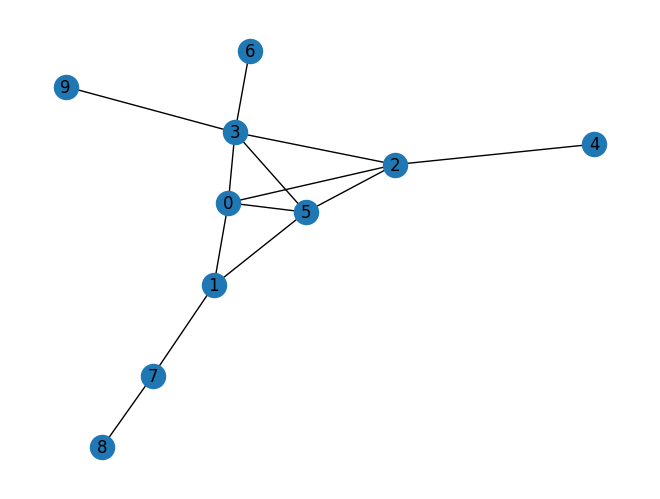

In [13]:
import networkx as nx
import numpy as np

from sklearn.preprocessing import normalize

nx_g = nx.Graph()

nx_g.add_edges_from([(0, 1), (0, 2),  (2, 3), (2, 4), (3,5 ), (0,3), (0,5), (1,5), (3,6), (2,5), (1,7),(8,7), (3,9)])
nx.draw(nx_g,with_labels = True)
num_nodes = 10

In [14]:
Ak = np.matrix(np.identity(num_nodes))
adj = nx.adjacency_matrix(nx_g)
adj= adj.todense()
adj = normalize(adj, axis=1, norm='l1')
adj = np.round(adj,2)
adj

array([[0.  , 0.25, 0.25, 0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.33, 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.33, 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.2 , 0.  , 0.2 , 0.  , 0.  , 0.2 , 0.2 , 0.  , 0.  , 0.2 ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [15]:
Ak = np.matrix(np.identity(num_nodes))


In [16]:
for i in range(4):
    Ak = np.dot(Ak, adj)
    print(f'Step: {i+1}')
    print(np.round(Ak,2))

Step: 1
[[0.   0.25 0.25 0.25 0.   0.25 0.   0.   0.   0.  ]
 [0.33 0.   0.   0.   0.   0.33 0.   0.33 0.   0.  ]
 [0.25 0.   0.   0.25 0.25 0.25 0.   0.   0.   0.  ]
 [0.2  0.   0.2  0.   0.   0.2  0.2  0.   0.   0.2 ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]]
Step: 2
[[0.26 0.06 0.11 0.12 0.06 0.2  0.05 0.08 0.   0.05]
 [0.08 0.33 0.16 0.16 0.   0.08 0.   0.   0.16 0.  ]
 [0.11 0.12 0.42 0.12 0.   0.11 0.05 0.   0.   0.05]
 [0.1  0.1  0.1  0.55 0.05 0.1  0.   0.   0.   0.  ]
 [0.25 0.   0.   0.25 0.25 0.25 0.   0.   0.   0.  ]
 [0.2  0.06 0.11 0.12 0.06 0.26 0.05 0.08 0.   0.05]
 [0.2  0.   0.2  0.   0.   0.2  0.2  0.   0.   0.2 ]
 [0.16 0.   0.   0.   0.   0.16 0.   0.66 0.   0.  ]
 [0.   0.5  0.   0.   0.   0.

# 3. Grarep

In [17]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

In [18]:
class GraRep(object):
    def __init__(self, A, args):
        """
        :param A: Adjacency matrix.
        :param args: Arguments object.
        """
        self.A = A
        self.args = args
        self._setup_base_target_matrix()

    def _setup_base_target_matrix(self):
        """
        Creating a base matrix to multiply.
        """
        values = [1.0 for _ in range(self.A.shape[0])]
        indices = [i for i in range(self.A.shape[0])]
        self.A_hat = sparse.coo_matrix((values, (indices, indices)),
                                       shape=self.A.shape,
                                       dtype=np.float32)

    def _create_target_matrix(self):
        """
        Creating a log transformed target matrix.
        :return target_matrix: Matrix to decompose with SVD.
        """
        self.A_hat = sparse.coo_matrix(self.A_hat.dot(self.A))
        scores = np.log(self.A_hat.data)-math.log(self.A.shape[0])
        rows = self.A_hat.row[scores < 0]
        cols = self.A_hat.col[scores < 0]
        scores = scores[scores < 0]
        target_matrix = sparse.coo_matrix((scores, (rows, cols)),
                                          shape=self.A.shape,
                                          dtype=np.float32)
        return target_matrix

    def optimize(self):
        """
        Learning an embedding.
        """
        print("\nOptimization started.\n")
        self.embeddings = []
        for step in tqdm(range(self.args["order"])):
            target_matrix = self._create_target_matrix()

            svd = TruncatedSVD(n_components=self.args["dim"],
                               n_iter=self.args["iter"],
                               random_state=self.args["seed"])

            svd.fit(target_matrix)
            embedding = svd.transform(target_matrix)
            self.embeddings.append(embedding)

    def return_embedding(self):
        """
        Return the embedding.
        """
        print("\nReturn embedding.\n")
        self.embeddings = np.concatenate(self.embeddings, axis=1)
        column_count = self.args["order"] * self.args["dim"]
        columns = ["ID"] + ["x_" + str(col) for col in range(column_count)]
        ids = np.array([i for i in range(self.A.shape[0])]).reshape(-1,1)
        self.embeddings = np.concatenate([ids, self.embeddings], axis=1)
        self.embeddings = pd.DataFrame(self.embeddings, columns=columns)
        
        return self.embeddings

In [19]:
args = {
    "dim": 16,
    "order": 5,
    "seed": 42,
    "iter": 20
}

grarep = GraRep(cora_A, args)

grarep.optimize()


Optimization started.



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


In [20]:
grarep_emb_csv = grarep.return_embedding()


Return embedding.



In [21]:
grarep_emb_csv.head()

,ID,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79
0,0.0,1.015238e-02,-2.169817e-03,1.437280e-01,1.009172e+00,8.098223e-01,-3.940892e-01,2.978217e-01,-6.929460e-01,1.714931e-01,...,-3.366572e+00,5.535538e+00,1.596764e+01,-3.711625e+01,-1.492708e+01,3.046616e+01,-1.278549e+01,-1.549975e+00,-2.911164e+01,-1.759281e+01
1,1.0,1.072093e-02,1.526770e-02,4.235009e-02,3.196161e-01,3.119746e-01,-1.467796e-01,-3.059230e-01,4.631628e-01,-2.039444e-01,...,-1.413198e+01,-4.048077e+01,-4.035257e+00,-3.567316e+01,1.938946e+01,-4.598905e+01,-2.640668e+01,3.564900e+00,-4.190806e+00,-2.997675e+00
2,2.0,1.526115e-01,-1.863606e-01,4.833708e-01,3.027579e+00,-2.805322e+00,1.243398e+00,-2.464836e+00,3.673813e+00,-1.590380e+00,...,5.532574e+01,1.242958e+01,2.171005e+01,1.771171e+01,-1.731554e+01,-3.478605e+01,-1.019112e+00,2.357077e+01,3.062950e+01,-2.291610e+01
3,3.0,2.154708e-15,6.079251e-12,9.957916e-11,6.907454e-07,-4.008898e-07,3.152383e-07,3.387929e-07,-6.484045e-07,1.702986e-07,...,-2.029157e-09,-1.706886e-09,-4.646332e-09,4.145217e-10,1.057346e-08,-2.821529e-09,1.178667e-09,-1.344967e-08,-1.604943e-08,-1.506433e-08
4,4.0,5.264034e-01,3.600548e-01,-6.969177e-02,-6.821089e-03,-8.024978e-03,3.797458e-04,9.982117e-03,-1.795001e-02,-1.989294e-02,...,1.140577e+01,-9.705548e+00,-2.789512e+01,7.369332e-01,-4.549699e+00,3.274813e+00,-6.257275e+00,-9.857273e+00,4.166501e+00,-3.421003e+00


# 4. Metapath2vec

In [22]:
import torch
from torch_geometric.nn.models import MetaPath2Vec

In [23]:
metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(aminer_data.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=6)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [24]:
def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))


@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=aminer_data['author'].y_index.to(device))
    y = aminer_data['author'].y

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=150)

In [ ]:
for epoch in range(5):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

Epoch: 0, Step: 00100/13231, Loss: 9.1002


# 5. WL-relabeling

In [ ]:
def wlk_relabel(g,h):
    '''
    Perform node relabeling (coloring) according 1-d WL relabeling process (refer Shervashidze et al (2009) paper)
    :param g: networkx graph
    :param h: height of WL kernel
    :return: relabeled graph
    '''
    for i in range(len(g.nodes)):
        g.nodes[i]['relabel'] = {}
        
    for i in range(0,h+1): #xrange returns [min,max)
        for n in range(len(g.nodes)):
            # degree_prefix = 'D' + str(i)
            degree_prefix = ''
            if 0 == i:
                g.nodes[n]['relabel'][0] = degree_prefix + str(g.nodes[n]['label']).strip() + degree_prefix
            else:
                nei_labels = [g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g,n)]
                nei_labels.sort()
                sorted_nei_labels = (','*i).join(nei_labels)

                current_in_relabel = g.nodes[n]['relabel'][i-1] +'#'*i+ sorted_nei_labels
                g.nodes[n]['relabel'][i] = degree_prefix + current_in_relabel.strip() + degree_prefix
    return g #relabled graph

In [ ]:
def fill_labels(G):
    for i in range(len(G.nodes)):
        G.nodes[i]['label'] = '1'

In [ ]:
def draw_graph(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['relabel']
        print(f'Node ID {n}: colour: {c}')
        col = 0
        if c=='1':
            clubs.append('green')
        elif c =='2':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph

In [ ]:
G = nx.Graph([
    (0, 1),
    (1 ,2), 
    (1 ,3),
    (1 ,5),
    (2 ,3),
    (2 ,4),
    (2 ,6),
    (3 ,4),
    (3 ,5),
    (4 ,7),
    (4 ,8),
    (6 ,7)])
fill_labels(G)
nx.draw(G, with_labels = True)

In [ ]:
relabeled_G = wlk_relabel(G, 1)

In [ ]:
draw_graph(relabeled_G)